In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
VIS_HIGHLINE=0.9825*100
VISHIGHLINE_ERR=0.0137*100

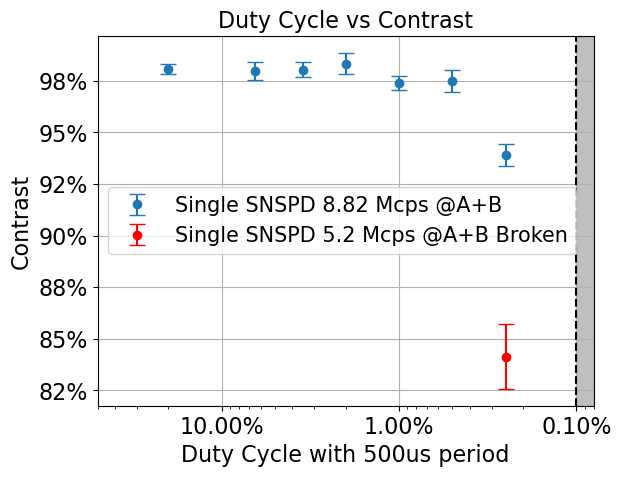

In [94]:
duty_cycle_df=pd.read_csv('dutyCycle.csv')
duty_cycle_df['cps']*=1e3
duty_cycle_df['dutyCycle']=duty_cycle_df['ref']/500/2
duty_cycle_df['cps']=duty_cycle_df['cps']/duty_cycle_df['dutyCycle']
duty_cycle_df['mean_cps']=duty_cycle_df['cps']
_cps_7M_index=(duty_cycle_df['mean_cps']>7e6)&(duty_cycle_df['contrast']>0.5)
_index_2_borken=1
mean_cps_7M=np.mean(duty_cycle_df['mean_cps'][_cps_7M_index])/1e6
plt.errorbar(duty_cycle_df['dutyCycle'][_cps_7M_index],duty_cycle_df['contrast'][_cps_7M_index],yerr=duty_cycle_df['err'][_cps_7M_index],fmt='o',capsize=6,label='Single SNSPD {:.2f} Mcps @A+B'.format(mean_cps_7M))
plt.errorbar(duty_cycle_df['dutyCycle'][_index_2_borken],duty_cycle_df['contrast'][_index_2_borken],yerr=duty_cycle_df['err'][_index_2_borken],fmt='o',capsize=6,c='red',label='Single SNSPD 5.2 Mcps @A+B Broken')
plt.axvline(0.001,color='k',linestyle='--')
## 灰色填充虚线右边
plt.axvspan(0.001,8e-4,color='gray',alpha=0.5)
plt.legend()
plt.title('Duty Cycle vs Contrast')
plt.gca().invert_xaxis()
plt.xlabel('Duty Cycle with 500us period')
plt.xscale('log')
plt.ylabel('Contrast')
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
plt.xlim(5e-1,8e-4)
plt.grid()
plt.show()


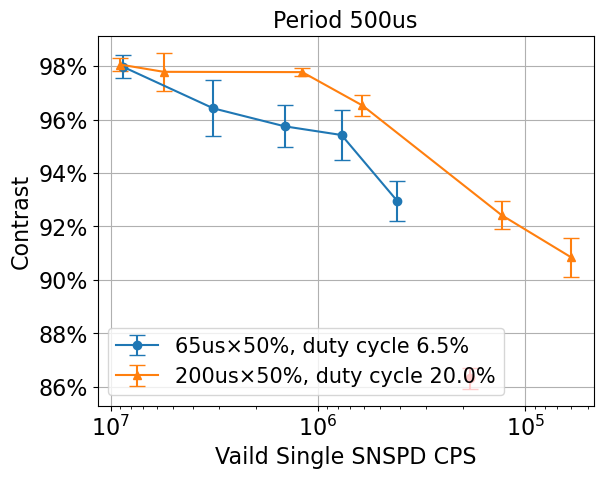

In [95]:
ref65_df=duty_cycle_df[duty_cycle_df['ref']==65]
ref200_df=duty_cycle_df[duty_cycle_df['ref']==200]
broken_index=ref65_df['contrast']<90
# 连线平滑处理
from scipy.interpolate import make_interp_spline

plt.errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o-',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2))
plt.errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
#三角形形状
plt.errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^-',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2))
## x轴反转
plt.legend()
plt.title('Period 500us')
plt.gca().invert_xaxis()
plt.xlabel('Vaild Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.grid()
plt.show()


1. 当测量窗口的相位变化$\Delta\varphi_{window}=\sigma\sqrt{\tau}$与散粒噪声$\Delta\varphi_{shot}=(\frac{1}{\sqrt{2N\tau}})$持平时  
  $\Delta\varphi=(\frac{\sigma^2}{2N})^{1/4}$
2. 对比度变化为
  $\gamma=A\cos{\Delta\varphi}$

65us Fitted parameters: a=99.26, b=8.97802, sigma=113.97513
200us Fitted parameters: a=100.00, b=7.07935, sigma=70.86579


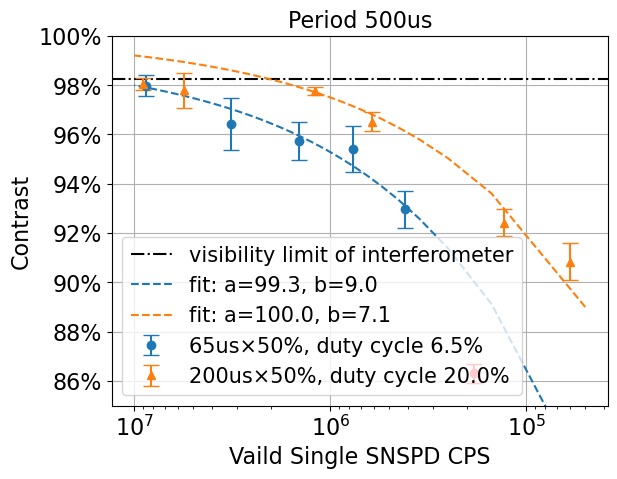

In [96]:
# 指数衰减拟合
from scipy.optimize import curve_fit
def cos_func(x,a,b):
    return a * np.cos(b*np.power(x,-1/4))

# 拟合数据
popt_65, pcov_65 = curve_fit(cos_func, ref65_df['cps'][1:], ref65_df['contrast'][1:], p0=(100, 1),sigma=ref65_df['err'][1:],)
popt_200, pcov_200 = curve_fit(cos_func, ref200_df['cps'][:-2], ref200_df['contrast'][:-2], p0=(100, 1),sigma=ref200_df['err'][:-2],)
x_fit = np.linspace(5e4, 1e7, 100)  
y_fit_65 = cos_func(x_fit, *popt_65)
y_fit_200 = cos_func(x_fit, *popt_200)
print('65us Fitted parameters: a={:.2f}, b={:.5f}, sigma={:.5f}'.format(*popt_65,popt_65[1]**2*1.414))
print('200us Fitted parameters: a={:.2f}, b={:.5f}, sigma={:.5f}'.format(*popt_200,popt_200[1]**2*1.414))

limit_line = plt.axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)

plt.plot(x_fit, y_fit_65, '--', label='fit: a={:.1f}, b={:.1f}'.format(*popt_65),color='C0')
plt.errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2),color='C0')
plt.errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
plt.plot(x_fit, y_fit_200, '--', label='fit: a={:.1f}, b={:.1f}'.format(*popt_200),color='C1')
plt.errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2),color='C1')

plt.xscale('log')
plt.title('Period 500us')
plt.gca().invert_xaxis()
plt.xlabel('Vaild Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
plt.legend()
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.ylim(85,100)
plt.grid()
plt.show()

In [97]:
ref200_df

,ref,cps,contrast,err,dutyCycle,mean_cps
13,200.0,60000.0,90.843,0.734,0.2,60000.0
14,200.0,130000.0,92.423,0.536,0.2,130000.0
15,200.0,610000.0,96.526,0.391,0.2,610000.0
16,200.0,1190000.0,97.774,0.156,0.2,1190000.0
17,200.0,5550000.0,97.785,0.715,0.2,5550000.0
18,200.0,9000000.0,98.057,0.234,0.2,9000000.0


65us Fitted parameters: a=99.26, sigma=8.97802
200us Fitted parameters: a=98.80, sigma=6.50055


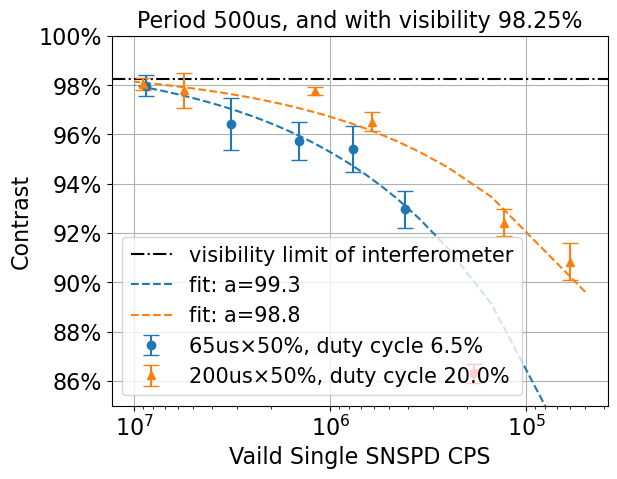

In [98]:
# 指数衰减拟合
from scipy.optimize import curve_fit
def cos_func(x,a,b):
    # a=VIS_HIGHLINE
    return a * np.cos(b*np.power(x,-1/4))

p0=(100,1)
# 调整拟合界限 - 可以根据实际需求修改这些值
# bound = ((lower_bound_for_a, lower_bound_for_b), (upper_bound_for_a, upper_bound_for_b))
bound = ((VIS_HIGHLINE-3*VISHIGHLINE_ERR, -np.inf), (VIS_HIGHLINE+3*VISHIGHLINE_ERR, np.inf))

# 拟合数据
popt_65, pcov_65 = curve_fit(cos_func, ref65_df['cps'][1:], ref65_df['contrast'][1:], p0=p0,sigma=ref65_df['err'][1:],bounds=bound)
popt_200, pcov_200 = curve_fit(cos_func, ref200_df['cps'][ref200_df.index!=16], ref200_df['contrast'][ref200_df.index!=16], p0=p0,sigma=ref200_df['err'][ref200_df.index!=16],bounds=bound)
x_fit = np.linspace(5e4, 1e7, 100)  
y_fit_65 = cos_func(x_fit, *popt_65)
y_fit_200 = cos_func(x_fit, *popt_200)
print('65us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_65,popt_65[0]**2*1.414))
print('200us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_200,popt_200[0]**2*1.414))

limit_line = plt.axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)

plt.plot(x_fit, y_fit_65, '--', label='fit: a={:.1f}'.format(*popt_65),color='C0')
plt.errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2),color='C0')
plt.errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
plt.plot(x_fit, y_fit_200, '--', label='fit: a={:.1f}'.format(*popt_200),color='C1')
plt.errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2),color='C1')

plt.xscale('log')
plt.title('Period 500us, and with visibility {:.2f}%'.format(VIS_HIGHLINE))
plt.gca().invert_xaxis()
plt.xlabel('Vaild Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
plt.legend()
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.ylim(85,100)
plt.grid()
plt.show()

In [99]:
c0,c1,c2,c3,c4="#d9042b","#730220","#03658c","#f29f05","#f27b50"

65us Fitted parameters: a=99.26, sigma=8.97802
200us Fitted parameters: a=98.80, sigma=6.50055


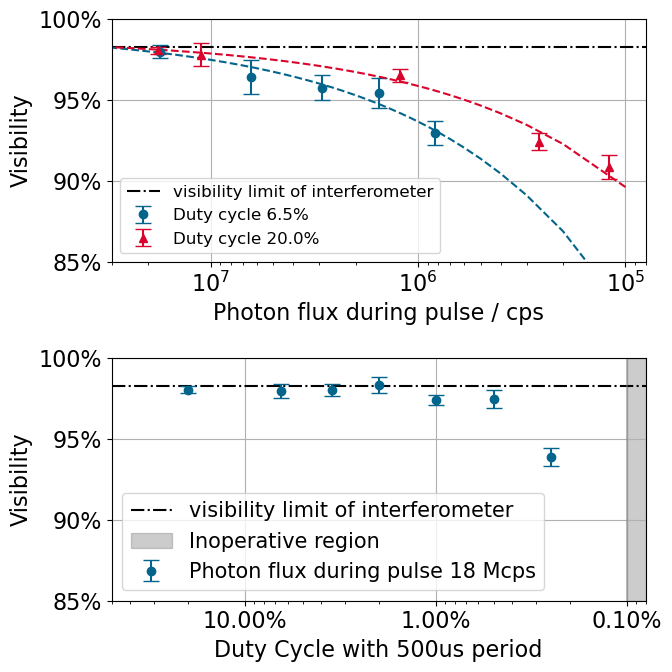

In [119]:
from scipy.optimize import curve_fit
def cos_func(x,a,b):
    # a=VIS_HIGHLINE
    return a * np.cos(b*np.power(x,-1/4))

p0=(98,1)
# 调整拟合界限 - 可以根据实际需求修改这些值
# bound = ((lower_bound_for_a, lower_bound_for_b), (upper_bound_for_a, upper_bound_for_b))
bound = ((VIS_HIGHLINE-VISHIGHLINE_ERR, -np.inf), (VIS_HIGHLINE+VISHIGHLINE_ERR, np.inf))

# 拟合数据
popt_65, pcov_65 = curve_fit(cos_func, ref65_df['cps'][1:], ref65_df['contrast'][1:], p0=p0,sigma=ref65_df['err'][1:],bounds=bound)
popt_200, pcov_200 = curve_fit(cos_func, ref200_df['cps'][ref200_df.index!=16], ref200_df['contrast'][ref200_df.index!=16], p0=p0,sigma=ref200_df['err'][ref200_df.index!=16],bounds=bound)
x_fit = np.linspace(5e4, 1e8, 2000)  
y_fit_65 = cos_func(x_fit, *popt_65)
y_fit_200 = cos_func(x_fit, *popt_200)
print('65us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_65,popt_65[0]**2*1.414))
print('200us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_200,popt_200[0]**2*1.414))


fig,axs=plt.subplots(2,1,figsize=(7,7),sharey=True)
limit_line = axs[0].axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)
fit_65_line=axs[0].plot(x_fit*2, y_fit_65, '--', label='fit: a={:.1f}'.format(*popt_65),color=c2)
exp_65_line=axs[0].errorbar(ref65_df['cps'][1:]*2,ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='Duty cycle {:.1%}'.format(65/500/2),color=c2)
# broke_65_line=axs[0].errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
fit_200_line=axs[0].plot(x_fit*2, y_fit_200, '--', label='fit: a={:.1f}'.format(*popt_200),color=c0)
exp_200_line=axs[0].errorbar(ref200_df['cps'][ref200_df.index!=16]*2,ref200_df['contrast'][ref200_df.index!=16],yerr=ref200_df['err'][ref200_df.index!=16],fmt='^',capsize=6,label='Duty cycle {:.1%}'.format(200/500/2),color=c0)
# 只显示errbar 的label
axs[0].legend(handles=[limit_line,exp_65_line,exp_200_line],fontsize=12)

axs[0].set_xscale('log')
# axs[0].set_title('CPS vs Contrast')
axs[0].invert_xaxis()
axs[0].set_xlabel('Photon flux during pulse / cps')
axs[0].set_xscale('log')
axs[0].set_ylabel('Visibility')
# axs[0].legend()
## y轴百分比
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
axs[0].set_ylim(85,100)
axs[0].set_xlim(1.5e7*2,4e4*2)
axs[0].grid()

duty_cycle_df=pd.read_csv('dutyCycle.csv')
duty_cycle_df['cps']*=1e3
duty_cycle_df['dutyCycle']=duty_cycle_df['ref']/500/2
duty_cycle_df['cps']=duty_cycle_df['cps']/duty_cycle_df['dutyCycle']
duty_cycle_df['mean_cps']=duty_cycle_df['cps']
_cps_7M_index=(duty_cycle_df['mean_cps']>7e6)&(duty_cycle_df['contrast']>0.5)
_index_2_borken=1
mean_cps_7M=np.mean(duty_cycle_df['mean_cps'][_cps_7M_index])/1e6

limit_line = axs[1].axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
axs[1].errorbar(duty_cycle_df['dutyCycle'][_cps_7M_index],duty_cycle_df['contrast'][_cps_7M_index],yerr=duty_cycle_df['err'][_cps_7M_index],color=c2,fmt='o',capsize=6,label='Photon flux during pulse {:.0f} Mcps'.format(mean_cps_7M*2))
# axs[1].errorbar(duty_cycle_df['dutyCycle'][_index_2_borken],duty_cycle_df['contrast'][_index_2_borken],yerr=duty_cycle_df['err'][_index_2_borken],fmt='o',capsize=6,c='red',label='Single SNSPD 5.2 Mcps @A+B Broken')
axs[1].axvline(0.001,color='gray',linestyle='-',alpha=0.5)
## 灰色填充虚线右边
axs[1].axvspan(0.001,8e-4,color='gray',alpha=0.397,label='Inoperative region')
axs[1].legend()
# axs[1].set_title('Duty Cycle vs Contrast')
axs[1].invert_xaxis()
axs[1].set_xlabel('Duty Cycle with 500us period')
axs[1].set_xscale('log')
axs[1].set_ylabel('Visibility')
## y轴百分比
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
axs[1].set_xlim(5e-1,8e-4)
axs[1].grid()
plt.tight_layout()
plt.savefig('SM_FIG1_DUTY_CPS_VIS.pdf',dpi=500)
plt.show()



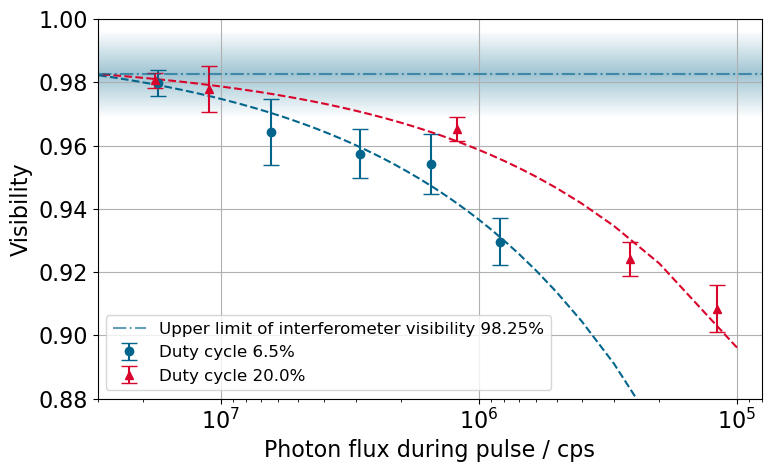

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches

# 4. 创建图表
plt.rcParams.update({
    'font.size': 16,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 16,    # x轴刻度字体大小
    'ytick.labelsize': 16,    # y轴刻度字体大小
    'legend.fontsize': 15     # 图例字体大小
})

fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
axs=[ax1]
# limit_line = axs[0].axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)
fit_65_line=axs[0].plot(x_fit*2, y_fit_65, '--', label='fit: a={:.1f}'.format(*popt_65),color=c2)
exp_65_line=axs[0].errorbar(ref65_df['cps'][1:]*2,ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='Duty cycle {:.1%}'.format(65/500/2),color=c2)
# broke_65_line=axs[0].errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
fit_200_line=axs[0].plot(x_fit*2, y_fit_200, '--', label='fit: a={:.1f}'.format(*popt_200),color=c0)
exp_200_line=axs[0].errorbar(ref200_df['cps'][ref200_df.index!=16]*2,ref200_df['contrast'][ref200_df.index!=16],yerr=ref200_df['err'][ref200_df.index!=16],fmt='^',capsize=6,label='Duty cycle {:.1%}'.format(200/500/2),color=c0)
axs[0].set_xscale('log')
x_min, x_max = axs[0].get_xlim()
# 只显示errbar 的label
## 绘制上限区域
limit_line = ax1.axhline(VIS_HIGHLINE,ls='-.',color=c2,label='Upper limit of interferometer visibility {:.2%}'.format(VIS_HIGHLINE*1e-2),alpha=0.618)
axs[0].legend(handles=[limit_line,exp_65_line,exp_200_line],fontsize=12)


## 区域用渐变色填充 - 从中间向两边渐变
# 获取当前轴的x轴范围

# 创建渐变填充
y_low = VIS_HIGHLINE - VISHIGHLINE_ERR
y_high = VIS_HIGHLINE + VISHIGHLINE_ERR
n_bins = 100  # 使用的颜色数量

# 确保c2是正确的颜色格式
if isinstance(c2, str):
    # 如果c2是颜色名称，使用matplotlib的颜色转换器
    from matplotlib.colors import to_rgba
    base_color = to_rgba(c2)
else:
    base_color = c2

# 从中间向两边渐变（水平方向）
# 确定中间点
x_mid = (x_min + x_max) / 2

# 使用多个矩形补丁来创建渐变效果
for i in range(n_bins):
    # 计算当前矩形的y坐标范围（垂直渐变）
    y_start = y_low + (y_high - y_low) * i / n_bins
    y_end = y_low + (y_high - y_low) * (i + 1) / n_bins
    if i > n_bins/2:
        i-=n_bins/2
        # 透明度从高到低
        alpha = 0.381 - (0.381 * i / n_bins*2)  # 从0.7到0.0的透明度渐变
    else:
        # 透明度从低到高（或从高到低）
        alpha = 0.0 + (0.381 * i / n_bins*2)  # 从0.0到0.7的透明度渐变
    
    # 创建矩形补丁
    rect = patches.Rectangle((x_min, y_start), x_max - x_min, y_end - y_start,
                             facecolor=base_color, alpha=alpha, edgecolor='none', zorder=0)
    ax1.add_patch(rect)


# 重置x轴范围（因为添加补丁可能会改变它）
# ax1.set_xlim(x_min, x_max)

# axs[0].set_title('CPS vs Contrast')
axs[0].invert_xaxis()
axs[0].set_xlabel('Photon flux during pulse / cps')
axs[0].set_ylabel('Visibility')
# axs[0].legend()
## y轴百分比
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x*1e-2)))
axs[0].set_ylim(88,100)
axs[0].set_xlim(1.5e7*2,4e4*2)
axs[0].grid()
plt.tight_layout()
plt.savefig('dutycycle_cps_vis.pdf',dpi=1000)
plt.show()


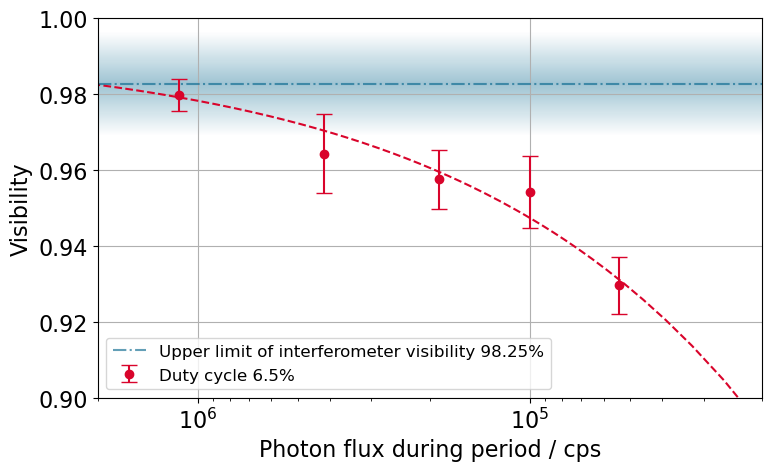

In [114]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches

# 4. 创建图表
plt.rcParams.update({
    'font.size': 16,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 16,    # x轴刻度字体大小
    'ytick.labelsize': 16,    # y轴刻度字体大小
    'legend.fontsize': 15     # 图例字体大小
})
fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
axs=[ax1]
# limit_line = axs[0].axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)
fit_65_line=axs[0].plot(x_fit*0.065*2, y_fit_65, '--', label='fit: a={:.1f}'.format(*popt_65),color=c0)
exp_65_line=axs[0].errorbar(ref65_df['cps'][1:]*0.065*2,ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='Duty cycle {:.1%}'.format(65/500/2),color=c0)
# broke_65_line=axs[0].errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
# fit_200_line=axs[0].plot(x_fit, y_fit_200, '--', label='fit: a={:.1f}'.format(*popt_200),color=c0)
# exp_200_line=axs[0].errorbar(ref200_df['cps'][ref200_df.index!=16],ref200_df['contrast'][ref200_df.index!=16],yerr=ref200_df['err'][ref200_df.index!=16],fmt='^',capsize=6,label='Duty cycle {:.1%}'.format(200/500/2),color=c0)
axs[0].set_xscale('log')
axs[0].set_ylim(90,100)
axs[0].set_xlim(1e6*2,1e4*2)
x_min, x_max = axs[0].get_xlim()
# 只显示errbar 的label
## 绘制上限区域
limit_line = ax1.axhline(VIS_HIGHLINE,ls='-.',color=c2,label='Upper limit of interferometer visibility {:.2%}'.format(VIS_HIGHLINE*1e-2),alpha=0.618)
axs[0].legend(handles=[limit_line,exp_65_line],fontsize=12)

## 区域用渐变色填充 - 从中间向两边渐变
# 获取当前轴的x轴范围
# 创建渐变填充
y_low = VIS_HIGHLINE - VISHIGHLINE_ERR
y_high = VIS_HIGHLINE + VISHIGHLINE_ERR
n_bins = 100  # 使用的颜色数量

# 确保c2是正确的颜色格式
if isinstance(c2, str):
    # 如果c2是颜色名称，使用matplotlib的颜色转换器
    from matplotlib.colors import to_rgba
    base_color = to_rgba(c2)
else:
    base_color = c2

# 从中间向两边渐变（水平方向）
# 确定中间点
x_mid = (x_min + x_max) / 2

# 使用多个矩形补丁来创建渐变效果
for i in range(n_bins):
    # 计算当前矩形的y坐标范围（垂直渐变）
    y_start = y_low + (y_high - y_low) * i / n_bins
    y_end = y_low + (y_high - y_low) * (i + 1) / n_bins
    if i > n_bins/2:
        i-=n_bins/2
        # 透明度从高到低
        alpha = 0.381 - (0.381 * i / n_bins*2)  # 从0.7到0.0的透明度渐变
    else:
        # 透明度从低到高（或从高到低）
        alpha = 0.0 + (0.381 * i / n_bins*2)  # 从0.0到0.7的透明度渐变
    
    # 创建矩形补丁
    rect = patches.Rectangle((x_min, y_start), x_max - x_min, y_end - y_start,
                             facecolor=base_color, alpha=alpha, edgecolor='none', zorder=0)
    ax1.add_patch(rect)


# 重置x轴范围（因为添加补丁可能会改变它）
# ax1.set_xlim(x_min, x_max)

# axs[0].set_title('CPS vs Contrast')
# axs[0].invert_xaxis()
axs[0].set_xlabel('Photon flux during period / cps')
axs[0].set_ylabel('Visibility')
# axs[0].legend()
## y轴百分比
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x*1e-2)))
axs[0].grid()
plt.tight_layout()
plt.savefig('dutycycle_cps_vis_65us.pdf',dpi=1000)
plt.show()

